## Fulldays Model Example
This notebook goes over how to use the suite of functions and tools for working with Fulldays data and a full walkthrough of training a simple model to predict a temperature profile! This covers all steps from loading -> model creation -> training -> evaluation!

#### A Note on Data Keys (`DKey`)
You may notice the usage of the 'DKey' enum throughout these examples. This is because it's the primary means of identifying
the datasets without resorting to "magic strings". To clarify, when defining the datasets to load such as HSEL and ATMS, we don't use the strings "HSEL" and "ATMS" but rather `DKey.HSEL` and `DKey.ATMS`. 

This may seem like extra work or a bit tedious but it provides a level of protection against accidental typos with a specifically defined list of `DKey` (located in `data/fulldays/loading.py` module). Moreover, any attempts at using a non-existant `DKey` will result in an immediate type error. Also, if you're using intellisense in your IDE, you can directly see the list of available `DKey` without needing to guess or check where they're defined.

### Loading Entire Datasets
The most effective way to load our fulldays data is by using the `FullDaysDataset` object.

The idea is that you make a `FullDaysDataset` instance for each of your train, test, and validation data.

A function called `get_split_datasets` has been provided to make this process as simple as possible.

In [ ]:
from hympi_ml.data.fulldays import DKey, DPath, get_split_datasets
from hympi_ml.utils.gpu import set_gpus

set_gpus(min_free=0.8) # selects one GPU with at least 80% or less usage!

# load the train, validation, and test datasets for an HSEL+CPL -> TEMPERATURE model
(train, validation, test) = get_split_datasets(
    data_path=DPath.CPL_06_REDUCED,
    feature_names=[DKey.HSEL, DKey.CPL],
    target_names=[DKey.TEMPERATURE],
    train_days=[
        "20060315",
        "20060515",
        "20060615",
        "20060715",
        "20060915",
        "20061015",
        "20061115",
        "20061215",
    ],
    validation_days=["20060815"],
    test_days=["20060803"],
    scale_ranges={DKey.TEMPERATURE: (175, 315)}, # define scale ranges for min-max scaling a given DKey of data!
    autolog=False, # this is made False as we are not using MLFlow in these examples (make it True if so!)
)

print("-Dataset Specs-")
print(f"Train: {train.element_spec}")
print(f"Validation: {validation.element_spec}")
print(f"Test: {test.element_spec}")

-Dataset Specs-
Train: ({<DKey.HSEL: 'HSEL'>: TensorSpec(shape=(1957,), dtype=tf.float64, name=None), <DKey.CPL: 'CPL'>: TensorSpec(shape=(733,), dtype=tf.float64, name=None)}, {<DKey.TEMPERATURE: 'TEMPERATURE'>: TensorSpec(shape=(72,), dtype=tf.float64, name=None)})
Validation: ({<DKey.HSEL: 'HSEL'>: TensorSpec(shape=(1957,), dtype=tf.float64, name=None), <DKey.CPL: 'CPL'>: TensorSpec(shape=(733,), dtype=tf.float64, name=None)}, {<DKey.TEMPERATURE: 'TEMPERATURE'>: TensorSpec(shape=(72,), dtype=tf.float64, name=None)})
Test: ({<DKey.HSEL: 'HSEL'>: TensorSpec(shape=(1957,), dtype=tf.float64, name=None), <DKey.CPL: 'CPL'>: TensorSpec(shape=(733,), dtype=tf.float64, name=None)}, {<DKey.TEMPERATURE: 'TEMPERATURE'>: TensorSpec(shape=(72,), dtype=tf.float64, name=None)})


That's it! In just 20 lines we can load all of our data that we need for training, validation, and test almost immedately!

Lots of the properties in a `FullDaysDataset` are setup as dictionaries which can be indexed using a `DKey`.

### Model Creation
Thanks to various useful functions provided by any instance of a `FullDaysDataset`, making models is very easy!

No need to remember the exact size of your features, simply use the `get_input_layers` function to create a dictionary of named keras `Input` layers. 

Since it's a dictionary, you can use the `DKey`, shown earlier, to index into the input layers!

In [5]:
import keras
from keras.layers import Dense, Concatenate, LayerNormalization

from hympi_ml.utils import gpu

gpu.set_gpus(min_free=0.8) # handle GPU finding automatically!

# Create input layers
input_layers = train.get_input_layers()

# Define the HSEL path
hsel_in = input_layers[DKey.HSEL]
hsel_out = LayerNormalization()(hsel_in)
hsel_out = Dense(256, "relu")(hsel_out)
hsel_out = Dense(64, "relu")(hsel_out)

# Define the CPL path
cpl_in = input_layers[DKey.CPL]
cpl_out = LayerNormalization()(cpl_in)
cpl_out = Dense(128, "relu")(cpl_out)
cpl_out = Dense(32, "relu")(cpl_out)

# Combine paths into final output
out = Concatenate()([hsel_out, cpl_out])
out = Dense(64, "relu")(out)

output_layers = train.get_output_layers()

for name in output_layers.keys():
    output_layers[name] = output_layers[name](out)

# only the values (the actual layers) are used for creating the model inputs and outputs
model = keras.Model(list(input_layers.values()), list(output_layers.values()))

model.compile("adam", "mae")

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 HSEL (InputLayer)              [(None, 1957)]       0           []                               
                                                                                                  
 CPL (InputLayer)               [(None, 733)]        0           []                               
                                                                                                  
 layer_normalization_4 (LayerNo  (None, 1957)        3914        ['HSEL[0][0]']                   
 rmalization)                                                                                     
                                                                                                  
 layer_normalization_5 (LayerNo  (None, 733)         1466        ['CPL[0][0]']              

Very easy! We created an entire model without ever needing to remember the data shapes or manually insert them into the Dense layers!

### Training

Once again, training is quite simple! However, it comes with an extra step.

You *cannot* directly use the sequences that are part of the `train.features` dictionary or `train.target` value. 

Instead, we need to generate our *own* batches! We can do this with the `create_batches` function which is part of any `FullDaysDataset`. 

These batches are a special kind of Keras-specific `Sequence` type that is specially used for generating our data. This is useful for the massive size of our datasets. These batches are used directly as the data passed into a `fit` function for a Keras model.

In [7]:
import tensorflow as tf

# Training
batch_size = 2000

train_ds = (
    train.as_tf_dataset()
    .shuffle(buffer_size=batch_size, reshuffle_each_iteration=True)
    .batch(batch_size)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)

val_ds = validation.as_tf_dataset().batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds = test.as_tf_dataset().batch(batch_size).prefetch(tf.data.AUTOTUNE)

model.fit(train_ds, validation_data=val_ds, epochs=1, verbose=1)

3771/3771 [==============================] - 497s 132ms/step - loss: 0.0245 - val_loss: 0.0234


### Evaluation
We couldn't end this example without some great tools for evaluation!

The options available in `hympi_ml/evaluation/figs.py` are expansive! Lots of great tools for creating figures automatically! 

It also includes some automatic logging for MLFlow models! 

The below example uses a few "EvalFigure" instances to show specific figures on the test dataset.

803/803 [==============================] - 18s 23ms/step


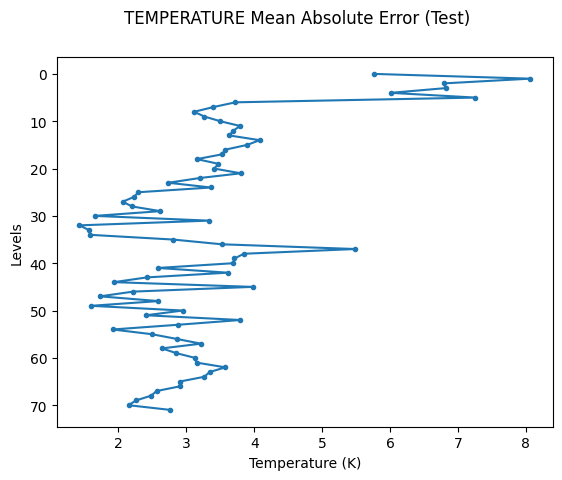

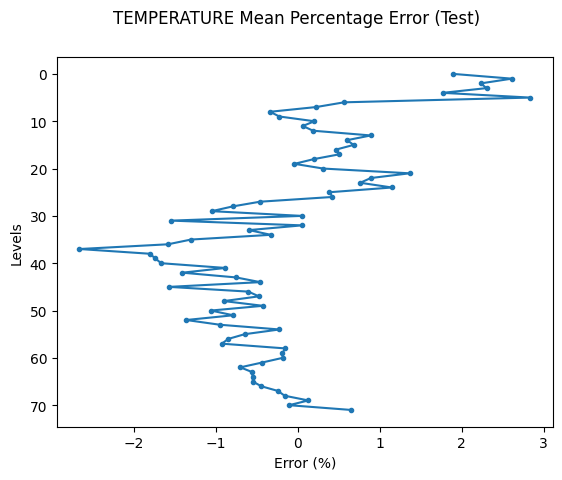

In [10]:
from hympi_ml.evaluation import figs

test_preds = test.predict(model, unscale=True)  # you can unscale predictions!
test_truths = test.get_targets(scaling=False)  # make sure to not scale if you are unscaling predictions as well!

figures = figs.plot_eval_figures(
    preds=test_preds,
    truths=test_truths,
    eval_figures=[
        figs.MeanErrorProfile(absolute=True, percentage=False),
        figs.MeanErrorProfile(absolute=False, percentage=True),
    ],
    context="Test",
)

for figure in figures:
    figure.show()

That's it! There lots more involved in the process of working with this data but I hope this simple tutorial provides a good starting off point for working with this special system. Please feel free to look through the code itself to see all of the wonderful features a `FullDaysDataset` has to offer!